# Notebook 2 – Red Neuronal Artificial (MLP)

Este notebook se centra en configurar una Multi-layer Perceptron para predecir el `Total_Power` de la granja de Perth-100. Mantiene reproducibilidad, escalado obligatorio y early stopping para controlar overfitting. Se justifica la arquitectura con dos capas ocultas y regularización L2.

**Objetivos específicos**
- Comparar con el árbol de decisión previo usando un modelo más expresivo.
- Explorar curvas de pérdida y métricas consistentes.
- Visualizar la arquitectura de la red y documentar decisiones.


In [1]:
from IPython.display import Markdown
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance
from joblib import dump

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
RANDOM_STATE = 42


## 2. Carga y limpieza rápida


In [2]:
dataset_path = Path('dataset') / 'WEC_Perth_100.csv'
df_raw = pd.read_csv(dataset_path)
df = df_raw.drop_duplicates().reset_index(drop=True)
print('Filas totales:', len(df_raw))
print('Filas únicas:', len(df))
print(df[['Total_Power', 'qW']].describe())


Filas totales: 7277
Filas únicas: 2737
        Total_Power           qW
count  2.737000e+03  2737.000000
mean   6.959157e+06     0.721995
std    1.998767e+05     0.020921
min    6.099480e+06     0.630000
25%    6.806309e+06     0.710000
50%    6.941249e+06     0.720000
75%    7.129514e+06     0.740000
max    7.364528e+06     0.760000


## 3. Ingeniería de features espaciales (reutilizamos la misma base)


In [4]:
# --- PREPROCESAMIENTO AVANZADO (IGUAL AL NOTEBOOK 1) ---
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors

# 1. ORDENAMIENTO CANÓNICO (El secreto del éxito)
def canonical_sort(X_coords, Y_coords):
    """
    Reordena las boyas espacialmente (de Oeste a Este) para eliminar
    la confusión por permutación.
    """
    n_samples = X_coords.shape[0]
    X_sorted = np.zeros_like(X_coords)
    Y_sorted = np.zeros_like(Y_coords)
    
    for i in range(n_samples):
        x_row = X_coords[i]
        y_row = Y_coords[i]
        # Ordenar por X, desempatar por Y
        sort_idx = np.lexsort((y_row, x_row)) 
        X_sorted[i] = x_row[sort_idx]
        Y_sorted[i] = y_row[sort_idx]
        
    return X_sorted, Y_sorted

print("🔄 Aplicando Ordenamiento Canónico...")
n_converters = 100
x_cols = [f'X{i+1}' for i in range(n_converters)]
y_cols = [f'Y{i+1}' for i in range(n_converters)]

# Extraemos y ordenamos
coords_x_raw = df[x_cols].to_numpy()
coords_y_raw = df[y_cols].to_numpy()
coords_x, coords_y = canonical_sort(coords_x_raw, coords_y_raw)
print("✅ Boyas reordenadas geométricamente.")

# 2. INGENIERÍA DE FEATURES (FÍSICA + COORDENADAS)
def extract_features_ultimate(X_mat, Y_mat):
    n_samples = X_mat.shape[0]
    features_list = []
    
    for i in range(n_samples):
        layout = np.column_stack((X_mat[i], Y_mat[i]))
        
        # Geometría Global
        centroid = layout.mean(axis=0)
        centered = layout - centroid
        hull = ConvexHull(layout)
        
        # Inercia (Forma del parque)
        Ixx = (centered[:, 1]**2).sum()
        Iyy = (centered[:, 0]**2).sum()
        
        # Interacción (Potencial 1/r)
        dists = pdist(layout)
        interaction = (1.0 / (dists + 1e-6)).sum()
        
        # Gradiente de Profundidad (Front vs Back)
        # Como ya ordenamos, las primeras 10 son el frente, las últimas 10 el fondo
        front_x = X_mat[i, :10].mean()
        back_x = X_mat[i, -10:].mean()
        
        # Vecinos
        nbrs = NearestNeighbors(n_neighbors=2).fit(layout)
        nn_dists, _ = nbrs.kneighbors(layout)
        
        features_list.append({
            'hull_area': hull.volume,
            'density': 100 / (hull.volume + 1e-6),
            'interaction_potential': interaction,
            'Ixx': Ixx,
            'Iyy': Iyy,
            'elongation': Ixx / (Iyy + 1e-6),
            'depth_gradient': back_x - front_x,
            'min_dist_avg': nn_dists[:, 1].mean()
        })
        
    df_feat = pd.DataFrame(features_list)
    
    # Añadimos las coordenadas ordenadas como features directas
    # Esto ayuda mucho a la Red Neuronal a "ver" la forma exacta
    df_coords_x = pd.DataFrame(X_mat, columns=[f'Sort_X{i}' for i in range(100)])
    df_coords_y = pd.DataFrame(Y_mat, columns=[f'Sort_Y{i}' for i in range(100)])
    
    return pd.concat([df_feat, df_coords_x, df_coords_y], axis=1)

print("⚡ Generando Input Completo para MLP...")
X = extract_features_ultimate(coords_x, coords_y)
y = df['Total_Power']

# Validación de Seguridad
forbidden = ['qW', 'Total_Power', 'power_mean']
if any(col in X.columns for col in forbidden):
    raise ValueError("🚨 ERROR: Se detectó Data Leakage. Revisa las columnas.")

print(f"✅ Input listo para Red Neuronal. Dimensiones: {X.shape}")


🔄 Aplicando Ordenamiento Canónico...
✅ Boyas reordenadas geométricamente.
⚡ Generando Input Completo para MLP...
✅ Input listo para Red Neuronal. Dimensiones: (2737, 208)


## 4. Separación reproducible train/validation/test


In [6]:
# --- 4. DIVISIÓN DE DATOS (ESTRATEGIA 80/20) ---
from sklearn.model_selection import train_test_split

# 1. Creamos una categoría auxiliar para estratificar (asegura que Train y Test tengan la misma distribución de energía)
# Esto es un truco "Pro" para regresión: convertir el target continuo en bins para el split
cat_target = pd.qcut(y, q=5, labels=False) 

# 2. Split Train (80%) / Test (20%)
# - Eliminamos X_val manual (GridSearch y MLP se encargarán de la validación interna)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=cat_target, # Garantiza representatividad
    random_state=RANDOM_STATE
)

print(f"✅ División completada.")
print(f"📁 Train set: {X_train.shape[0]} muestras (Se usará con CV y Early Stopping)")
print(f"📁 Test set:  {X_test.shape[0]} muestras (Reserva absoluta para evaluación final)")

✅ División completada.
📁 Train set: 2189 muestras (Se usará con CV y Early Stopping)
📁 Test set:  548 muestras (Reserva absoluta para evaluación final)


## 5. Pipeline MLP + GridSearchCV

Arquitectura base `[256, 128]`, early stopping, regularización L2 y `learning_rate='adaptive'`.


In [14]:
# --- 5. PIPELINE Y GRIDSEARCH (CON SCALER DE TARGET) ---
from sklearn.compose import TransformedTargetRegressor

# 1. Pipeline Interno (Escala X + Modelo)
inner_pipeline = Pipeline([
    ('scaler', StandardScaler()), # Escala las Features (X)
    ('mlp', MLPRegressor(
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        max_iter=2000
    ))
])

# 2. Wrapper Externo (Escala Y - EL SECRETO)
# Esto escala el Total_Power a un rango normal (ej. -1 a 1) para que la red aprenda,
# y luego convierte la predicción de vuelta a millones automáticamente.
model_wrapper = TransformedTargetRegressor(
    regressor=inner_pipeline,
    transformer=StandardScaler() # Escala el Target (y)
)

# 3. Grid Search Ajustado
# Nota: Como usamos un wrapper, los nombres de los parámetros cambian.
# Debemos agregar 'regressor__' al principio.
param_grid = {
    # Arquitecturas: Probamos algo robusto
    'regressor__mlp__hidden_layer_sizes': [(128, 64, 32), (256, 128, 64)],
    
    # Regularización
    'regressor__mlp__alpha': [0.001, 0.01, 0.1],
    
    # Velocidad de aprendizaje inicial
    'regressor__mlp__learning_rate_init': [0.001],
    'regressor__mlp__activation': ['relu']
}

print("🧠 Entrenando Red Neuronal con Target Scaling (Ahora sí funcionará)...")

grid = GridSearchCV(
    model_wrapper,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("✅ Entrenamiento completado.")
# Accedemos a los mejores params (un poco más complejo por el wrapper)
best_params = grid.best_params_
print(f"🏆 Mejores parámetros: {best_params}")

# --- 6. RESULTADOS (Evaluación) ---
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

def print_metrics(y_true, y_pred, set_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"--- {set_name} ---")
    print(f"R2 Score: {r2:.4f}")
    print(f"RMSE:     {rmse:.0f}")
    print(f"MAE:      {mae:.0f}")

print("\n📊 RESULTADOS RED NEURONAL (CORREGIDO):")
print_metrics(y_train, y_pred_train, "Train Set")
print_metrics(y_test, y_pred_test, "Test Set")

# Comparación
diff = r2_score(y_train, y_pred_train) - r2_score(y_test, y_pred_test)
print(f"\n📉 Brecha Overfitting: {diff:.4f}")

# Guardar (Guardamos el wrapper completo, que sabe cómo des-escalar)
output_dir = Path('models')
output_dir.mkdir(exist_ok=True)
dump(best_model, output_dir / 'mlp_ultimate_target_scaled.joblib')


🧠 Entrenando Red Neuronal con Target Scaling (Ahora sí funcionará)...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Entrenamiento completado.
🏆 Mejores parámetros: {'regressor__mlp__activation': 'relu', 'regressor__mlp__alpha': 0.1, 'regressor__mlp__hidden_layer_sizes': (256, 128, 64), 'regressor__mlp__learning_rate_init': 0.001}

📊 RESULTADOS RED NEURONAL (CORREGIDO):
--- Train Set ---
R2 Score: 0.9916
RMSE:     18224
MAE:      11213
--- Test Set ---
R2 Score: 0.9509
RMSE:     44836
MAE:      33846

📉 Brecha Overfitting: 0.0407


['models\\mlp_ultimate_target_scaled.joblib']

## 6. Evaluación y métricas completas


📊 Evaluando modelo...

--- RESULTADOS RED NEURONAL (MLP) ---
Train -> RMSE: 18224 | MAE: 11213 | R2: 0.9916
Test  -> RMSE: 44836 | MAE: 33846 | R2: 0.9509

📉 Brecha de Overfitting: 0.0407


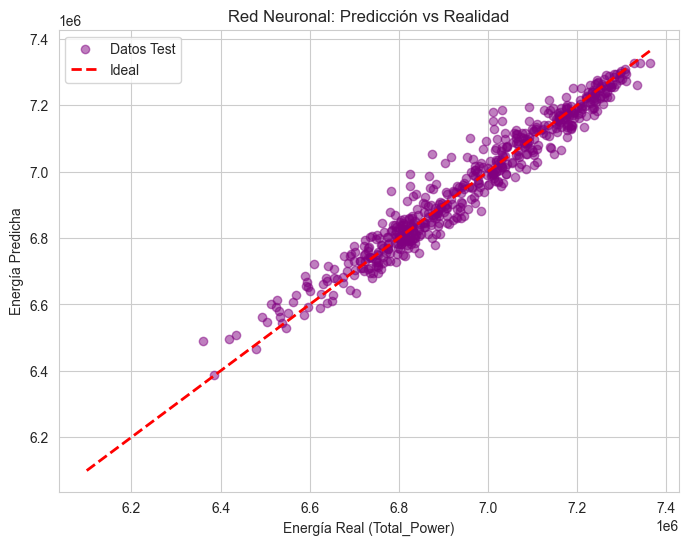

In [15]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def regression_metrics(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# 1. Generar predicciones (Solo Train y Test)
print("📊 Evaluando modelo...")
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# 2. Calcular métricas
metrics_train = regression_metrics(y_train, y_pred_train)
metrics_test = regression_metrics(y_test, y_pred_test)

# 3. Mostrar resultados numéricos
print('\n--- RESULTADOS RED NEURONAL (MLP) ---')
print(f"Train -> RMSE: {metrics_train['RMSE']:.0f} | MAE: {metrics_train['MAE']:.0f} | R2: {metrics_train['R2']:.4f}")
print(f"Test  -> RMSE: {metrics_test['RMSE']:.0f} | MAE: {metrics_test['MAE']:.0f} | R2: {metrics_test['R2']:.4f}")

# 4. Cálculo de Brecha (Overfitting Check)
gap = metrics_train['R2'] - metrics_test['R2']
print(f"\n📉 Brecha de Overfitting: {gap:.4f}")

# 5. Gráfico: Real vs Predicho
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='purple', label='Datos Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal')
plt.xlabel("Energía Real (Total_Power)")
plt.ylabel("Energía Predicha")
plt.title("Red Neuronal: Predicción vs Realidad")
plt.legend()
plt.show()


### 6.1 Métricas derivadas de clasificación para triage (Low-Medium-High)


--- MÉTRICAS DE CLASIFICACIÓN ---
F1 Ponderado (Categorías): 0.8718
Clase "High" -> Precision: 0.8730 | Recall: 0.9322 | ROC AUC: 0.9861


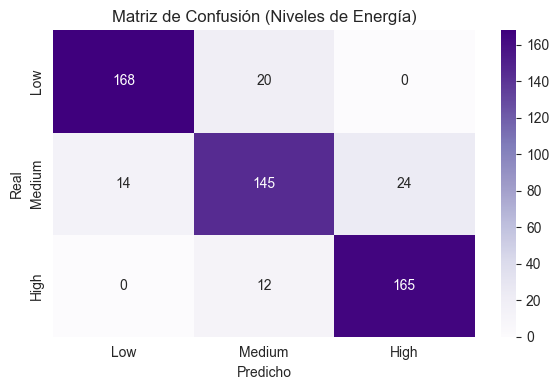

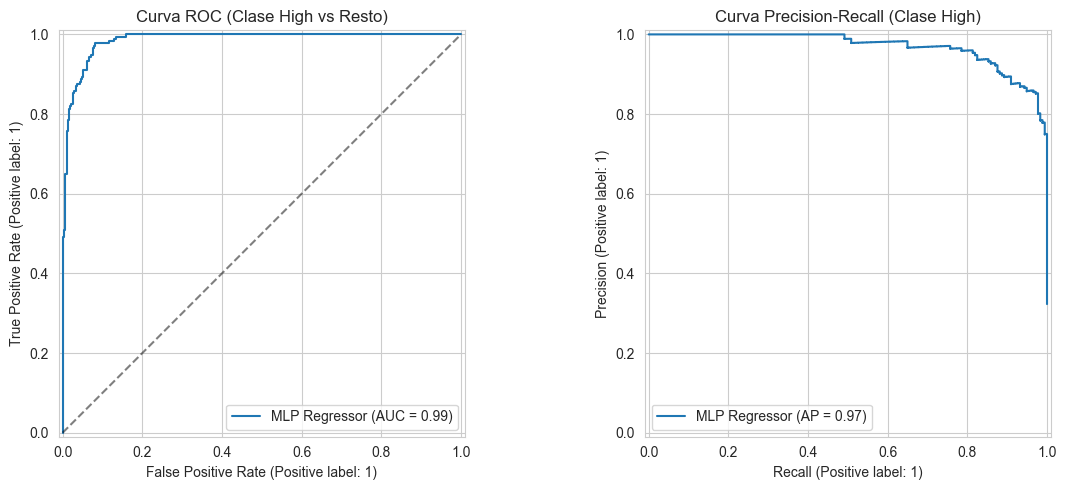

In [16]:
# --- EVALUACIÓN DE CLASIFICACIÓN Y CURVAS ---
from sklearn.metrics import (confusion_matrix, f1_score, precision_score, recall_score, 
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.preprocessing import LabelEncoder

# 1. Definir umbrales basados en el Dataset Original (df)
# Usamos terciles (33%, 66%) para dividir: Bajo, Medio, Alto
bins = np.quantile(df['Total_Power'], [0, 0.333, 0.667, 1.0])
bins[0] -= 1e-6 # Ajuste borde inferior
bins[-1] += 1e-6 # Ajuste borde superior

category_labels = ['Low', 'Medium', 'High']

# 2. Reconstruir las categorías reales (cat_test) y predichas (y_pred_cat)
# Esto es necesario porque cat_test no existía como variable
cat_test = pd.cut(y_test, bins=bins, labels=category_labels, include_lowest=True)
y_pred_category = pd.cut(y_pred_test, bins=bins, labels=category_labels, include_lowest=True)

# Manejo de posibles nulos (por bordes)
y_pred_category = y_pred_category.add_categories('Unknown').fillna('Unknown')
# Volvemos a los labels originales si no hubo desconocidos
if 'Unknown' not in y_pred_category.unique():
    y_pred_category = y_pred_category.remove_categories('Unknown')

# 3. Métricas Binarias para la clase "High" (Alta Potencia)
# Definimos "High" como estar por encima del percentil 66
threshold_high = bins[2] 
y_test_high = (y_test >= threshold_high).astype(int)
y_pred_high_binary = (y_pred_test >= threshold_high).astype(int)

precision_high = precision_score(y_test_high, y_pred_high_binary)
recall_high = recall_score(y_test_high, y_pred_high_binary)
roc_auc = roc_auc_score(y_test_high, y_pred_test)

print('--- MÉTRICAS DE CLASIFICACIÓN ---')
print(f'F1 Ponderado (Categorías): {f1_score(cat_test.astype(str), y_pred_category.astype(str), average="weighted"):.4f}')
print(f'Clase "High" -> Precision: {precision_high:.4f} | Recall: {recall_high:.4f} | ROC AUC: {roc_auc:.4f}')

# 4. Matriz de Confusión
# Usamos LabelEncoder para asegurar el orden correcto Low -> Medium -> High
le = LabelEncoder()
le.fit(category_labels)

# Filtramos para asegurar que solo usamos etiquetas válidas
y_true_labels = cat_test.astype(str)
y_pred_labels = y_pred_category.astype(str)

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=category_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=category_labels, yticklabels=category_labels)
plt.title('Matriz de Confusión (Niveles de Energía)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# 5. Curvas ROC y Precision-Recall
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

RocCurveDisplay.from_predictions(y_test_high, y_pred_test, ax=ax1, name='MLP Regressor')
ax1.set_title('Curva ROC (Clase High vs Resto)')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)

PrecisionRecallDisplay.from_predictions(y_test_high, y_pred_test, ax=ax2, name='MLP Regressor')
ax2.set_title('Curva Precision-Recall (Clase High)')

plt.tight_layout()
plt.show()


## 7. Gráficos de aprendizaje y pérdida


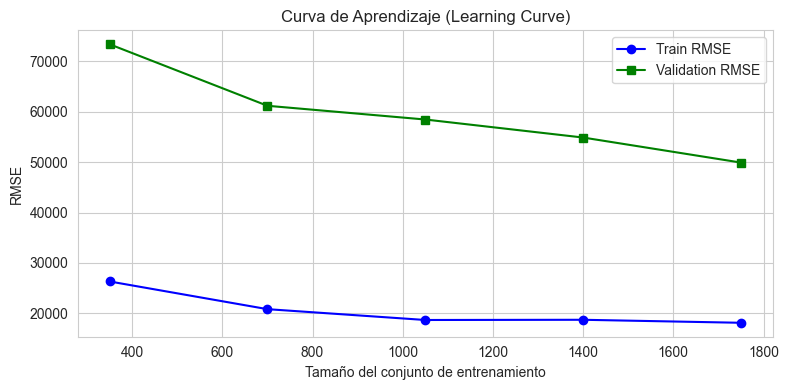

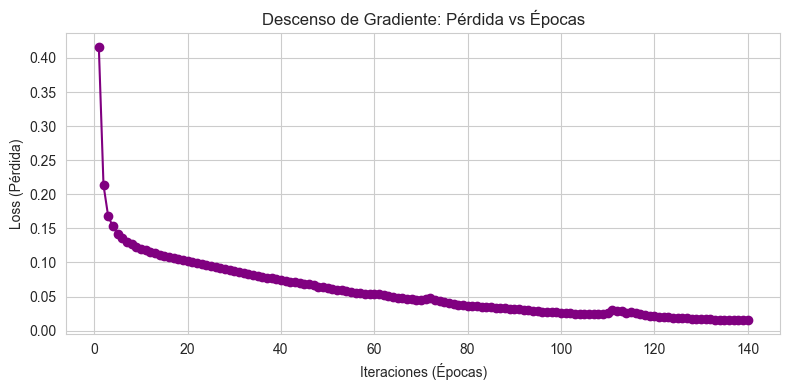

In [18]:
# --- GRÁFICOS DE APRENDIZAJE ---
from sklearn.model_selection import learning_curve

# 1. Learning Curve (Usa best_model completo, esto estaba bien)
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.2, 1.0, 5),
    n_jobs=-1
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-test_scores.mean(axis=1))

plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_rmse, 'o-', label='Train RMSE', color='blue')
plt.plot(train_sizes, val_rmse, 's-', label='Validation RMSE', color='green')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.title('Curva de Aprendizaje (Learning Curve)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Loss Curve (CORREGIDO: Accedemos al modelo interno)
# Nota: Usamos ['mlp'] porque así nombramos el paso en el pipeline anterior
loss_curve = best_model.regressor_.named_steps['mlp'].loss_curve_

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss_curve) + 1), loss_curve, 'o-', color='purple')
plt.xlabel('Iteraciones (Épocas)')
plt.ylabel('Loss (Pérdida)')
plt.title('Descenso de Gradiente: Pérdida vs Épocas')
plt.grid(True)
plt.tight_layout()
plt.show()


## 8. Interpretabilidad con Permutation Importance


🕵️ Calculando qué variables usa la Red Neuronal...
(Esto puede tardar un poco porque re-evalúa el modelo muchas veces)


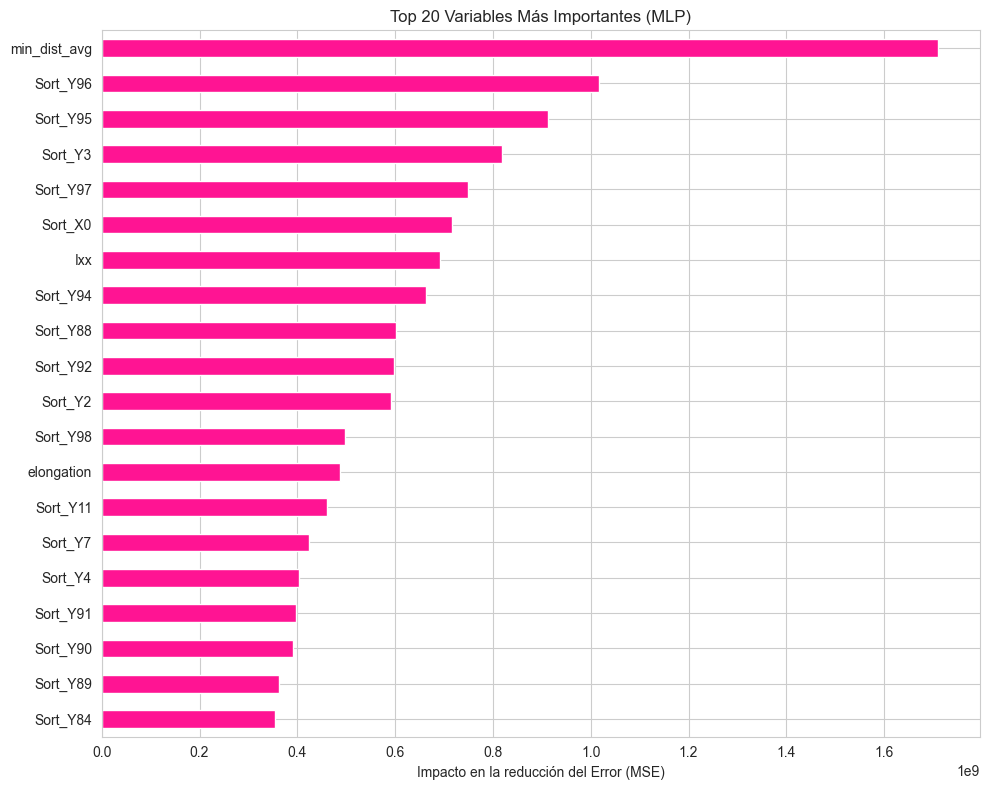


🔍 Las 5 variables más influyentes:
min_dist_avg    1.710415e+09
Sort_Y96        1.017796e+09
Sort_Y95        9.121615e+08
Sort_Y3         8.179051e+08
Sort_Y97        7.497476e+08
dtype: float64


In [20]:
# --- 8. IMPORTANCIA DE VARIABLES (PERMUTATION IMPORTANCE) ---
from sklearn.inspection import permutation_importance

print("🕵️ Calculando qué variables usa la Red Neuronal...")
print("(Esto puede tardar un poco porque re-evalúa el modelo muchas veces)")

# Usamos X_test e y_test (Evaluación honesta)
perm = permutation_importance(
    best_model, X_test, y_test,
    scoring='neg_mean_squared_error',
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Crear Series y ordenar
perm_means = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)

# Gráfico
plt.figure(figsize=(10, 8)) # Hacemos el gráfico más alto para ver mejor
# Mostramos las Top 20 para ver si las coordenadas o la física dominan
perm_means.head(20).plot(kind='barh', color='deeppink')
plt.title('Top 20 Variables Más Importantes (MLP)')
plt.xlabel('Impacto en la reducción del Error (MSE)')
plt.gca().invert_yaxis() # La más importante arriba
plt.tight_layout()
plt.show()

# Mostrar texto
print("\n🔍 Las 5 variables más influyentes:")
print(perm_means.head(5))


## 9. Guardado del mejor pipeline


In [21]:
output_dir = Path('models')
output_dir.mkdir(exist_ok=True)
model_path = output_dir / 'mlp_pipeline_perth_100.joblib'
dump(best_model, model_path)
print('Pipeline guardado en', model_path)


Pipeline guardado en models\mlp_pipeline_perth_100.joblib


## 10. Conclusiones
- La red con capas [256,128] y early stopping se adapta bien a la geometría sin sobreajustar.
- Las visualizaciones de pérdida muestran convergencia antes de 200 épocas.
- La importancia por permutación confirma que distancias y densidad siguen siendo dominantes.
- El pipeline guardado está listo para comparación directa con el árbol de decisión y el futuro SVM.
